In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.cbook import get_test_data
from metpy.units import units
import os
import scipy.integrate as integrate
import datetime as dt
import glob
import json
from datetime import datetime
from datetime import timedelta

from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

#import wrf
import scipy
#import xcape

In [3]:
os.chdir('/data/ecmwf')
#data = xr.open_dataset('ec_pl3_small.nc')
data_ml = xr.open_dataset('ec_ml.nc')
data_sfc = xr.open_dataset('ec_sfc2.nc')
#data_sfc2 = xr.open_dataset('ec_sfc.nc')

# View a summary of the Dataset
print(data_ml)
print(data_sfc)

<xarray.Dataset>
Dimensions:    (time: 48, longitude: 151, latitude: 101, level: 48)
Coordinates:
  * time       (time) datetime64[ns] 2022-12-22T01:00:00 ... 2022-12-24
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 0.4 ... 14.7 14.8 14.9 15.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * level      (level) float64 90.0 91.0 92.0 93.0 ... 134.0 135.0 136.0 137.0
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Thu Dec 22 06:55:07 2022: cdo merge uwind_ml.nc vwind_ml.nc...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
<xarray.Dataset>
Dimensions:    (longitude: 151, latitude: 101, time: 48)
Coordinates:
  * longitude  (longitude) 

In [83]:
# To parse the full dataset, we can call parse_cf without an argument, and assign the returned Dataset.

#data = data.metpy.parse_cf()
data_ml = data_ml.metpy.parse_cf()
data_sfc = data_sfc.metpy.parse_cf()

x, y = data_ml['u'].metpy.coordinates('x', 'y')

time = data_ml['u'].metpy.time

timeinit = time[0]
timeinit = datetime.utcfromtimestamp(timeinit.item()/1e9)-timedelta(hours=1)
print(timeinit)

sfcuwind =  data_sfc['u10']
sfcvwind =  data_sfc['v10']
mslp = data_sfc['msl']
mslp = mslp/100

#qv_bl = data_ml['q'].where(data_ml['q'].level>123, drop=True)
#qv_mean = np.mean(qv_bl, axis=1)
#qv_mean = qv_mean*1000

usfc = data_sfc['u10']
vsfc = data_sfc['v10']
t2 = data_sfc['t2m']
d2 = data_sfc['d2m']
z = data_sfc['z']

u50m = data_ml['u'].metpy.loc[{'level': 135}]
v50m = data_ml['v'].metpy.loc[{'level': 135}]
u100m = data_ml['u'].metpy.loc[{'level': 133}]
v100m = data_ml['v'].metpy.loc[{'level': 133}]
u200m = data_ml['u'].metpy.loc[{'level': 130}]
v200m = data_ml['v'].metpy.loc[{'level': 130}]
u250m = data_ml['u'].metpy.loc[{'level': 129}]
v250m = data_ml['v'].metpy.loc[{'level': 129}]
u300m = data_ml['u'].metpy.loc[{'level': 128}]
v300m = data_ml['v'].metpy.loc[{'level': 128}]
u400m = data_ml['u'].metpy.loc[{'level': 126}]
v400m = data_ml['v'].metpy.loc[{'level': 126}]
u500m = data_ml['u'].metpy.loc[{'level': 124}]
v500m = data_ml['v'].metpy.loc[{'level': 124}]
u750m = data_ml['u'].metpy.loc[{'level': 121}]
v750m = data_ml['v'].metpy.loc[{'level': 121}]
u1km = data_ml['u'].metpy.loc[{'level': 117}]
v1km = data_ml['v'].metpy.loc[{'level': 117}]



Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitud

2022-12-22 00:00:00


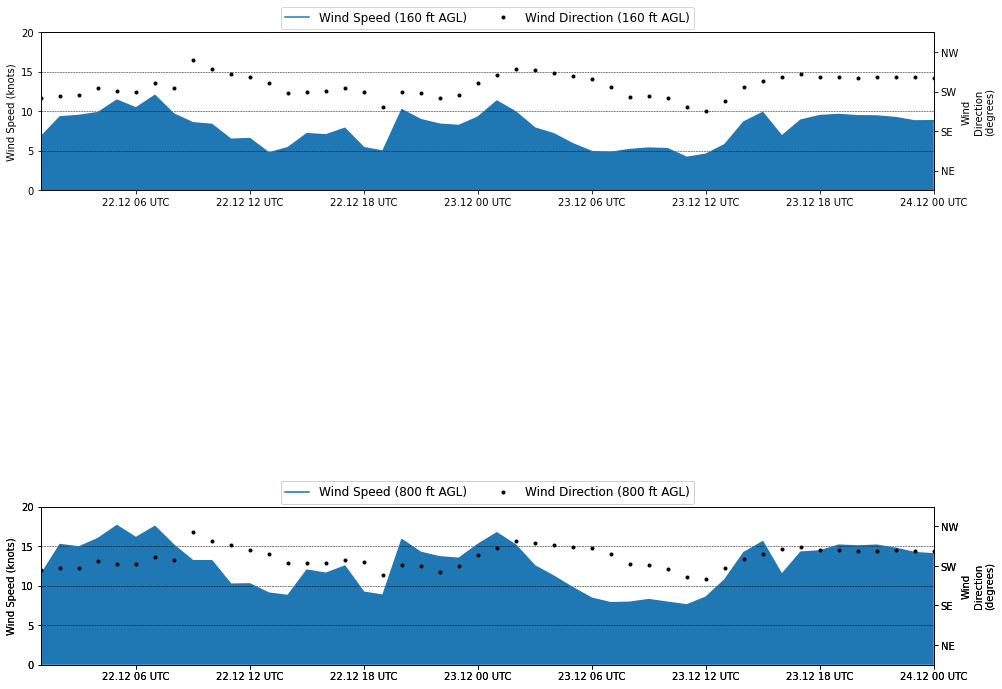

In [87]:
lat = 49.9
lon = 6.2

u250=u250m.metpy.loc[{'latitude': lat, 'longitude': lon}]
v250=v250m.metpy.loc[{'latitude': lat, 'longitude': lon}]
dir250=mpcalc.wind_direction(u250,v250,convention="from")
u50=u50m.metpy.loc[{'latitude': lat, 'longitude': lon}]
v50=v50m.metpy.loc[{'latitude': lat, 'longitude': lon}]
dir50=mpcalc.wind_direction(u50,v50,convention="from")
u100=u100m.metpy.loc[{'latitude': lat, 'longitude': lon}]
v100=v100m.metpy.loc[{'latitude': lat, 'longitude': lon}]
dir100=mpcalc.wind_direction(u100,v100,convention="from")
ws50=np.sqrt(u50.values**2+v50.values**2)
ws100=np.sqrt(u100.values**2+v100.values**2)
ws250=np.sqrt(u250.values**2+v250.values**2)

import matplotlib as mpl
class Meteogram:
    """ Plot a time series of meteorological data from a particular station as a
    meteogram with standard variables to visualize, including thermodynamic,
    kinematic, and pressure. The functions below control the plotting of each
    variable.
    TO DO: Make the subplot creation dynamic so the number of rows is not
    static as it is currently. """

    def __init__(self, fig, dates, probeid, time=None, axis=0):
        """
        Required input:
            fig: figure object
            dates: array of dates corresponding to the data
            probeid: ID of the station
        Optional Input:
            time: Time the data is to be plotted
            axis: number that controls the new axis to be plotted (FOR FUTURE)
        """
        if not time:
            time = dt.datetime.utcnow()
        self.start = dates[0]
        self.fig = fig
        self.end = dates[-1]
        self.axis_num = 0
        self.dates = mpl.dates.date2num(dates)
        self.time = time.strftime('%Y-%m-%d %H:%M UTC')
        self.title = f'Latest Ob Time: {self.time}\nProbe ID: {probeid}'
        
        
    def plot_winds50(self, ws, wd, plot_range=None):
        """
        Required input:
            ws: Wind speeds (knots)
            wd: Wind direction (degrees)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT WIND SPEED AND WIND DIRECTION
        self.ax1 = fig.add_subplot(4, 1, 1)
        ln1 = self.ax1.plot(self.dates, ws50, label='Wind Speed (160 ft AGL)')
        self.ax1.fill_between(self.dates, ws50, 0)
        self.ax1.set_xlim(self.start, self.end)
        if not plot_range:
            plot_range = [0, 20, 1]
        self.ax1.set_ylabel('Wind Speed (knots)', multialignment='center')
        self.ax1.set_ylim(plot_range[0], plot_range[1], plot_range[2])
        self.ax1.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)
    

        ax7 = self.ax1.twinx()
        ln2 = ax7.plot(self.dates, dir50, '.k', linewidth=0.5, label='Wind Direction (160 ft AGL)')
        ax7.set_ylabel('Wind\nDirection\n(degrees)', multialignment='center')
        ax7.set_ylim(0, 360)
        ax7.set_yticks(np.arange(45, 405, 90))
        ax7.set_yticklabels(['NE', 'SE', 'SW', 'NW'])
        lines = ln1  + ln2
        labs = [line.get_label() for line in lines]
        ax7.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m %H UTC'))
        ax7.legend(lines, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 12})
        
    def plot_winds100(self, ws, wd, plot_range=None):
        """
        Required input:
            ws: Wind speeds (knots)
            wd: Wind direction (degrees)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT WIND SPEED AND WIND DIRECTION
        self.ax2 = fig.add_subplot(4, 1, 2, sharex=self.ax1)
        ln3 = self.ax2.plot(self.dates, ws100m, label='Wind Speed (300 ft AGL)')
        self.ax2.fill_between(self.dates, ws100m, 0)
        self.ax2.set_xlim(self.start, self.end)
        if not plot_range:
            plot_range = [0, 20, 1]
        self.ax2.set_ylabel('Wind Speed (knots)', multialignment='center')
        self.ax2.set_ylim(plot_range[0], plot_range[1], plot_range[2])
        self.ax2.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)
    

        ax7 = self.ax2.twinx()
        ln4 = ax7.plot(self.dates, dir100, '.k', linewidth=0.5, label='Wind Direction (300 ft AGL)')
        ax7.set_ylabel('Wind\nDirection\n(degrees)', multialignment='center')
        ax7.set_ylim(0, 360)
        ax7.set_yticks(np.arange(45, 405, 90))
        ax7.set_yticklabels(['NE', 'SE', 'SW', 'NW'])
        lines = ln4  + ln3
        labs = [line.get_label() for line in lines]
        ax7.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m %H UTC'))
        ax7.legend(lines, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 12})
        
    def plot_winds250(self, ws, wd, plot_range=None):
        """
        Required input:
            ws: Wind speeds (knots)
            wd: Wind direction (degrees)
        Optional Input:
            plot_range: Data range for making figure (list of (min,max,step))
        """
        # PLOT WIND SPEED AND WIND DIRECTION
        self.ax3 = fig.add_subplot(4, 1, 3, sharex=self.ax1)
        ln5 = self.ax3.plot(self.dates, ws250m, label='Wind Speed (800 ft AGL)')
        self.ax3.fill_between(self.dates, ws250m, 0)
        self.ax3.set_xlim(self.start, self.end)
        if not plot_range:
            plot_range = [0, 20, 1]
        self.ax3.set_ylabel('Wind Speed (knots)', multialignment='center')
        self.ax3.set_ylim(plot_range[0], plot_range[1], plot_range[2])
        self.ax3.grid(b=True, which='major', axis='y', color='k', linestyle='--',
                      linewidth=0.5)
    

        ax7 = self.ax3.twinx()
        ln6 = ax7.plot(self.dates, dir250, '.k', linewidth=0.5, label='Wind Direction (800 ft AGL)')
        ax7.set_ylabel('Wind\nDirection\n(degrees)', multialignment='center')
        ax7.set_ylim(0, 360)
        ax7.set_yticks(np.arange(45, 405, 90))
        ax7.set_yticklabels(['NE', 'SE', 'SW', 'NW'])
        lines = ln5  + ln6
        labs = [line.get_label() for line in lines]
        ax7.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%m %H UTC'))
        ax7.legend(lines, labs, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 12})


data = {'wind_speed': (np.array(ws250) * units('m/s')).to(units('knots')),
        'wind_direction': np.array(dir250) * units('degrees'),
        'wind_speed50': (np.array(ws50) * units('m/s')).to(units('knots')),
        'wind_direction50': np.array(dir50) * units('degrees'),
        'wind_speed100': (np.array(ws100) * units('m/s')).to(units('knots')),
        'wind_direction100': np.array(dir100) * units('degrees'),
        'times': np.array(time)}

# ID For Plotting on Meteogram
probe_id = '0102A'

fig = plt.figure(figsize=(16, 16))
#add_metpy_logo(fig, 250, 180)
meteogram = Meteogram(fig, data['times'], probe_id)
meteogram.plot_winds50(data['wind_speed50'], data['wind_direction50'])
meteogram.plot_winds250(data['wind_speed100'], data['wind_direction100'])
meteogram.plot_winds250(data['wind_speed'], data['wind_direction'])
fig.subplots_adjust(hspace=0.5)
plt.show()